<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/W2D5_Initial/tutorials/W2D5_GenerativeModels/W2D5_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 5, Tutorial 3

# VAEs and GANs : Conditional GANs

__Content creators:__ Kai Xu, Seungwook Han, Akash Srivastava

__Content reviewers:__ Polina Turishcheva, Melvin Selim Atay, Hadi Vafaei, Deepak Raya

__Production editors:__ Arush Tagade, Spiros Chavlis

---

## Tutorial Objectives

The goal of this notebook is to understand conditional GANs.

By the end of this tutorial you will be able to:
- Understand the differences in conditional GANs
- Generate high-dimensional natural images from a BigGAN

In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1eP79mRMzD2Q7Utol3kZ5hooYIXRTQMMb" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [2]:
# Imports

# Install Huggingface BigGAN library
!pip install pytorch-pretrained-biggan --quiet
!pip install Pillow libsixel-python --quiet

# Import libraries
import nltk
import torch
import random
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names,
                                       truncated_noise_sample,
                                       save_as_images, display_in_terminal)


nltk.download('wordnet')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#@title Figure settings
from IPython.display import display
import ipywidgets
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# @title Set seed for reproducibility in Pytorch
# https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed):
  """
  Set random seed for reproducibility

  Args:
    seed: integer
      A positive integer to ensure reproducibility
  """
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  print(f'Seed {seed} has been set.')


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(522)

Seed 522 has been set.


---

# Section 1: Generating with a conditional GAN (BigGAN)

Video available at https://youtu.be/lV6zH2xDZck


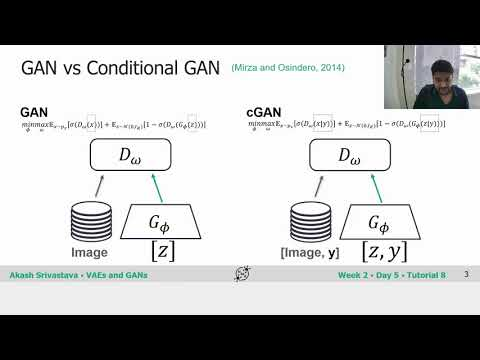

In [5]:
#@title Video 1: Conditional Generative Models
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="lV6zH2xDZck", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In this section, we will load a pre-trained conditional GAN, BigGAN, which is the state-of-the-art model in conditional high-dimensional natural image generation, and generate samples from it. Since it is a class conditional model, we will be able to use the class label to generate images from the respective classes of objects.

Read here for more details on BigGAN: https://arxiv.org/pdf/1809.11096.pdf

In [6]:
# Load respective BigGAN model for the specified resolution (biggan-deep-128, biggan-deep-256, biggan-deep-512)
def load_biggan(model_res):
  return BigGAN.from_pretrained('biggan-deep-{}'.format(model_res))


# Create class and noise vectors for sampling from BigGAN
def create_class_noise_vectors(class_str, trunc, num_samples):
  class_vector = one_hot_from_names([class_str]*num_samples, batch_size=num_samples)
  noise_vector = truncated_noise_sample(truncation=trunc, batch_size=num_samples)

  return class_vector, noise_vector


# Generate samples from BigGAN
def generate_biggan_samples(model, class_vector, noise_vector, truncation=0.4,
                            device=device):
  # Convert to tensor
  noise_vector = torch.from_numpy(noise_vector)
  class_vector = torch.from_numpy(class_vector)

  # Move to GPU
  noise_vector = noise_vector.to(device)
  class_vector = class_vector.to(device)
  model.to(device)

  # Generate an image
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1] range.
  # Clipping is only in case of numerical instability problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)
  output = output

  # Make grid and show generated samples
  output_grid = torchvision.utils.make_grid(output, nrow=min(4, output.shape[0]), padding=5)
  plt.imshow(output_grid.permute(1,2,0))

  return output_grid


def generate(b):
  # Create BigGAN model
  model = load_biggan(MODEL_RESOLUTION)

  # Use specified parameters (resolution, class, number of samples, etc) to generate from BigGAN
  class_vector, noise_vector = create_class_noise_vectors(CLASS, TRUNCATION, NUM_SAMPLES)
  samples_grid = generate_biggan_samples(model, class_vector, noise_vector, TRUNCATION, device)
  torchvision.utils.save_image(samples_grid, 'samples.png')
  ### If CUDA out of memory issue, lower NUM_SAMPLES (number of samples)

## Section 1.1:  Define configurations

We will now define the configurations (resolution of model, number of samples, class to sample from, truncation level) under which we will sample from BigGAN. 

***Question***: What is the truncation trick employed by BigGAN? How does sample variety and fidelity change by varying the truncation level? (Hint: play with the truncation slider and try sampling at different levels) 

In [7]:
#@title { run: "auto" }

### RUN THIS BLOCK EVERY TIME YOU CHANGE THE PARAMETERS FOR GENERATION

# Resolution at which to generate
MODEL_RESOLUTION = "256" #@param [128, 256, 512]

# Number of images to generate
NUM_SAMPLES = 1 #@param {type:"slider", min:1, max:100, step:1}

# Class of images to generate
CLASS = 'German shepherd' #@param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']

# Truncation level of the normal distribution we sample z from
TRUNCATION = 0.4 #@param {type:"slider", min:0.1, max:1, step:0.1}


In [8]:
# Create generate button, given parameters specified above
button = widgets.Button(description="GENERATE!",
                        layout=widgets.Layout(width='30%', height='80px'),
                        button_style='danger')
output = widgets.Output()
display(button, output)
button.on_click(generate)

Button(button_style='danger', description='GENERATE!', layout=Layout(height='80px', width='30%'), style=Button…

Output()

# Summary

In this section, we have learned: 
- How conditional GANs differ from unconditional models
- How to use a pre-trained BigGAN model to generate high-dimensional photo-realistic images and its tricks to modulate diversity and image fidelity

# Food for thought

1. How does BigGAN differ from previous state-of-the-art generative models for high-dimensional natural images? In other words, how does BigGAN solve high-dimensional image generation? (Hint: look into model architecture and training configurations) (BigGAN paper: https://arxiv.org/pdf/1809.11096.pdf) 
2. Continuing from Question 1, what are the drawbacks of introducing such techniques into training large models for high-dimensional, diverse datasets?
3. Play with other pre-trained generative models like StyleGAN here -- where code for sampling and interpolation in the latent space is available: https://github.com/NVlabs/stylegan